# Wildfire trends in California

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
import jenkspy
import altair_latimes as lat
import altair as alt
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
# processed @ wildfires/00_cleaning.ipynb
wildfires = gpd.read_file('/Users/mhustiles/data/data/GIS/wildfires/FRAP/output/wildfires.geojson')

In [3]:
wildfires['alarm_date'] = wildfires['alarm_date'].str.replace('T00:00:00', '')
wildfires['year_'] = wildfires['year_'].astype(int)

In [4]:
wildfires.columns

Index(['objectid', 'year_', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'comments', 'report_ac',
       'gis_acres', 'c_method', 'objective', 'fire_num', 'sqmiles',
       'alarm_year', 'alarm_quarter', 'alarm_day', 'alarm_month',
       'alarm_monthname', 'cause_description', 'agency_description',
       'unit_description', 'fire', 'geometry'],
      dtype='object')

In [25]:
wildfires.year_.value_counts()

2017    607
2008    431
2018    411
2012    350
2016    347
2007    346
2003    340
2011    317
2006    315
2015    311
2005    306
2013    298
1996    285
2004    274
1980    263
1999    259
2009    254
1987    251
2002    243
1981    239
2014    238
1988    219
2010    209
2001    204
1984    198
1994    194
1985    184
1995    178
2000    176
1997    166
1989    152
1986    151
1992    150
1983    148
1993    144
1998    143
1990    136
1982    132
1991     74
Name: year_, dtype: int64

---

In [6]:
result_decade = []

for value in wildfires['year_']: 
    if value > 1979 and value < 1990: 
        result_decade.append('1980s')
    elif value > 1989 and value < 2000: 
        result_decade.append('1990s')
    elif value > 1999 and value < 2010: 
        result_decade.append('2000s')
    else: 
        result_decade.append('2010s')
    
wildfires['decade'] = result_decade

In [7]:
result = []

for value in wildfires['year_']: 
    if value > 1979 and value < 1985: 
        result.append('1980-84')
    elif value > 1984 and value < 1990: 
        result.append('1985-89')
    elif value > 1989 and value < 1995: 
        result.append('1990-94')
    elif value > 1994 and value < 2000: 
        result.append('1995-99')
    elif value > 1999 and value < 2005: 
        result.append('2000-04')
    elif value > 2004 and value < 2010: 
        result.append('2005-09') 
    elif value > 2009 and value < 2015: 
        result.append('2010-14')
    else: 
        result.append('2015-18')
    
wildfires['half_decade'] = result

In [8]:
large_fires_decades = wildfires[wildfires['gis_acres'] > 5000].groupby(['decade'])\
    .agg({'gis_acres': [("sum", "sum"), ("count", "count")]}).reset_index().round()
large_fires_decades.columns = ["_".join(x) for x in large_fires_decades.columns.ravel()]

In [9]:
large_fires_years = wildfires[wildfires['gis_acres'] > 5000].groupby(['year_'])\
    .agg({'gis_acres': [("sum", "sum"), ("count", "count")]}).reset_index().round()
large_fires_years.columns = ["_".join(x) for x in large_fires_years.columns.ravel()]

In [10]:
large_fires_years.head(10)

,year__,gis_acres_sum,gis_acres_count
0,1980,"213,602",15
1,1981,"175,614",14
2,1982,"77,260",4
3,1983,"9,310",1
4,1984,"105,505",10
5,1985,"444,280",15
6,1986,"39,247",4
7,1987,"696,432",36
8,1988,"172,770",15
9,1989,"66,973",6


In [11]:
large_fires_decades.head(10)

,decade_,gis_acres_sum,gis_acres_count
0,1980s,"2,000,994",120
1,1990s,"2,342,828",116
2,2000s,"5,502,221",190
3,2010s,"5,912,600",167


In [12]:
acres = alt.Chart(large_fires_decades).mark_bar().encode(
    x='decade_:O',
    y='sum(gis_acres_sum):Q'
).properties(height=300, width=250)

count = alt.Chart(large_fires_decades).mark_bar().encode(
    x='decade_:O',
    y='sum(gis_acres_count):Q'
).properties(height=300, width=250)

acres|count

alt.HConcatChart(...)

In [13]:
acres_years = alt.Chart(large_fires_years).mark_bar().encode(
    x='year__:O',
    y='sum(gis_acres_sum):Q'
).properties(height=400, width=600)

acres_years

alt.Chart(...)

### Export for years summary table

In [14]:
large_fires_years.to_csv('output/large_fires_years.csv')

### Add CA counties

In [15]:
counties = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.\
latimes.com/archive/1.0/boundary-set/counties-2012.geojson')

In [16]:
## corresponds to census 'consolidated statistical area' 
la_csa = counties[(counties['name'] == 'Los Angeles') \
                   | (counties['name'] == 'Orange') \
                   | (counties['name'] == 'Ventura') \
                   | (counties['name'] == 'San Bernardino')\
                   | (counties['name'] == 'Riverside')]

In [17]:
## corresponds to census 'consolidated statistical area' 
la_county = counties[(counties['name'] == 'Los Angeles')]

In [18]:
la_area_fires = gpd.sjoin(wildfires, la_csa, op='within')
la_county_fires = gpd.sjoin(wildfires, la_county, op='intersects')

In [19]:
len(la_county_fires)

999

In [20]:
len(la_area_fires)

2147

In [21]:
len(wildfires)

9643

In [22]:
la_area_fires_lg = la_area_fires[la_area_fires['gis_acres'] > 1000 ]
la_county_fires_lg = la_county_fires[la_county_fires['gis_acres'] > 1000 ]

<AxesSubplot:>

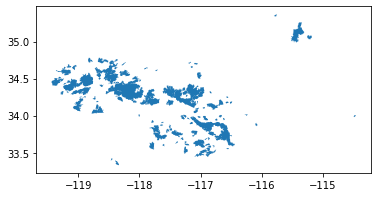

In [23]:
la_area_fires_lg.plot()

In [24]:
la_area_fires_lg.to_file('/Users/mhustiles/data/data/GIS/\
wildfires/FRAP/output/la_county_fires_lg.geojson', driver='GeoJSON')